In [1]:
import torch
import torchvision
import cv2
import numpy as np
device = torch.device("cpu")
model = torch.jit.load('model_traced_640_cpu.pt', map_location=device)

# torch.rand(size=(3,640,1000))

# print(model(torch.rand(size=(3,1000,1000))))
# print(list(model.parameters())[0].shape, list(model.parameters())[1].shape, list(model.parameters())[2].shape )

# print(model)

nW = 640
nH = 640

model.eval()
# model.cuda()

RecursiveScriptModule(
  original_name=TracingAdapter
  (model): RecursiveScriptModule(
    original_name=SWINTS
    (backbone): RecursiveScriptModule(
      original_name=FPN
      (fpn_lateral2): RecursiveScriptModule(original_name=Conv2d)
      (fpn_output2): RecursiveScriptModule(original_name=Conv2d)
      (fpn_lateral3): RecursiveScriptModule(original_name=Conv2d)
      (fpn_output3): RecursiveScriptModule(original_name=Conv2d)
      (fpn_lateral4): RecursiveScriptModule(original_name=Conv2d)
      (fpn_output4): RecursiveScriptModule(original_name=Conv2d)
      (fpn_lateral5): RecursiveScriptModule(original_name=Conv2d)
      (fpn_output5): RecursiveScriptModule(original_name=Conv2d)
      (top_block): RecursiveScriptModule(original_name=LastLevelMaxPool)
      (bottom_up): RecursiveScriptModule(
        original_name=SwinTransformer
        (patch_embed): RecursiveScriptModule(
          original_name=PatchEmbed
          (proj): RecursiveScriptModule(original_name=Conv2d)
    

In [2]:
input_img_path = "img_test/507777211.jpg"
img_orig = cv2.imread(input_img_path)

In [3]:

with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
    # Apply pre-processing to image.

    original_image = img_orig[:, :, ::-1]
    
    height, width = original_image.shape[:2]
        
    resized_image = cv2.resize(original_image, [nW, nH], interpolation = cv2.INTER_CUBIC)

    image = torch.as_tensor(resized_image.astype("float32").transpose(2, 0, 1)).to(device)
    
    predictions = model(image)
    
m, n = predictions[0].size()
results = torch.cat((predictions[0], predictions[3].view(m, 1)), 1)
results = results[results[:, 4] > 0.2]

# instances = predictions["instances"]
# instances = instances[instances.scores > confidence_threshold]
outputs = results[:, :4].detach().cpu().numpy()
print(outputs.shape)

save_path = "results_ts_output_2.jpg"
def plot(image, boxes, save_path, scale_w=nW/width, scale_h=nH/height):
    #image in the form of cv2.imread()
    # gn = torch.tensor(image.shape)[[1, 0, 1, 0]]  # normalization gain whwh
    tl = round(0.002 * (image.shape[0] + image.shape[1]) / 2) + 1  # line/font thickness
    N, _ = boxes.shape
    for i in range(N):
        color = [100, 50, 100]
        # print(box)
        cv2.rectangle(image, (int(boxes[i][0]/scale_w), int(boxes[i][1]/scale_h)), (int(boxes[i][2]/scale_w), int(boxes[i][3]/scale_h)), color, thickness=tl, lineType=cv2.LINE_AA)
    cv2.imwrite(save_path, image)

plot(img_orig, outputs, save_path)

(40, 4)


/home/ubuntu/OCR_research/env_ocr_research/lib/python3.7/site-packages/torch/nn/modules/module.py:1130: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:594.)
  return forward_call(*input, **kwargs)


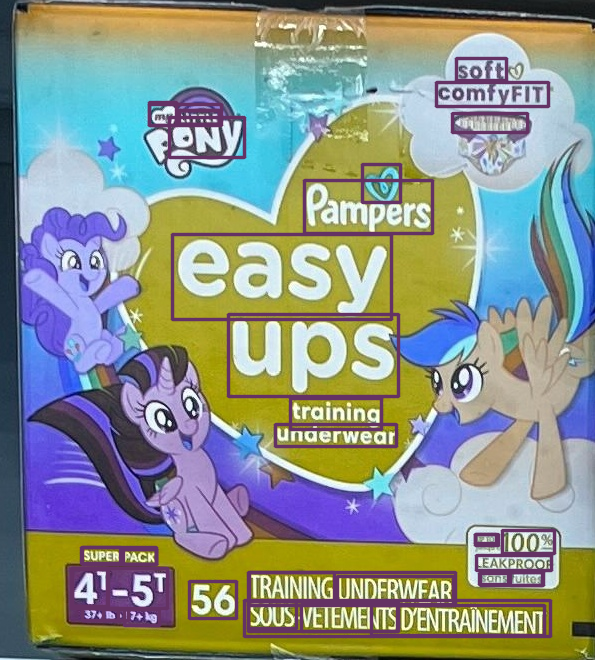

In [4]:
from PIL import Image
 
# creating a object

im_pil = Image.fromarray(img_orig) 

im_pil.show()

## ONNX conversion

In [5]:
print(torch.__version__)

1.12.1+cu116


In [7]:
# input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(16) ]
# output_names = [ "output1" ]

torch.onnx.export(model, image, "model_640.onnx", verbose=True, opset_version=16)

/home/ubuntu/OCR_research/env_ocr_research/lib/python3.7/site-packages/torch/onnx/utils.py:461: UserWarning: no signature found for <torch.ScriptMethod object at 0x7f98a996cc50>, skipping _decide_input_format
  warnings.warn("%s, skipping _decide_input_format" % e)
/home/ubuntu/OCR_research/env_ocr_research/lib/python3.7/site-packages/torchvision/ops/_register_onnx_ops.py:32: UserWarning: ROIAlign with aligned=True is not supported in ONNX, but will be supported in opset 16. The workaround is that the user need apply the patch https://github.com/microsoft/onnxruntime/pull/8564 and build ONNXRuntime from source.
  "ROIAlign with aligned=True is not supported in ONNX, but will be supported in opset 16. "
/home/ubuntu/OCR_research/env_ocr_research/lib/python3.7/site-packages/torch/onnx/symbolic_helper.py:544: UserWarning: Type cannot be inferred, which might cause exported graph to produce incorrect results.
  "Type cannot be inferred, which might cause exported graph to produce incorrect

In [ ]:
!pip3 install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu116